# Camera Calibration using Zhang's Method

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import scipy.linalg

## Load images to grayscale images

In [2]:
images_gray = []

dir_calib_name = "../data/calib01"
filenames = os.listdir(dir_calib_name)
for fname in filenames:
    fname_path = os.path.join(dir_calib_name, fname)
    print(fname)
    images_gray.append(cv.imread(fname_path, cv.IMREAD_GRAYSCALE))

print("Number of images: {}".format(len(images_gray)))

IMG_20170209_042606.jpg
IMG_20170209_042608.jpg
IMG_20170209_042610.jpg
IMG_20170209_042612.jpg
IMG_20170209_042614.jpg
IMG_20170209_042616.jpg
IMG_20170209_042619.jpg
IMG_20170209_042621.jpg
IMG_20170209_042624.jpg
IMG_20170209_042627.jpg
IMG_20170209_042629.jpg
IMG_20170209_042630.jpg
IMG_20170209_042634.jpg
Number of images: 13


## Find corners in chessboard images

In [3]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objp[:,:2] *= 21.5 # 21.5 mm is the size of each square in the chessboard
objp[:,2] = 1 # z coordinate is 0 since the chessboard is planar

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

corners = []
for img in tqdm(images_gray):
    #Find chessboard corners
    ret, corners = cv.findChessboardCorners(img, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(img, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

objpoints = np.array(objpoints)
imgpoints = np.array(imgpoints)

print("Object points shape: {}".format(objpoints.shape))
print("Image points shape: {}".format(imgpoints.shape))
print("Is found corners from all images? {}".format(imgpoints.shape[0] == len(images_gray)))

  0%|          | 0/13 [00:00<?, ?it/s]

Object points shape: (13, 54, 3)
Image points shape: (13, 54, 1, 2)
Is found corners from all images? True


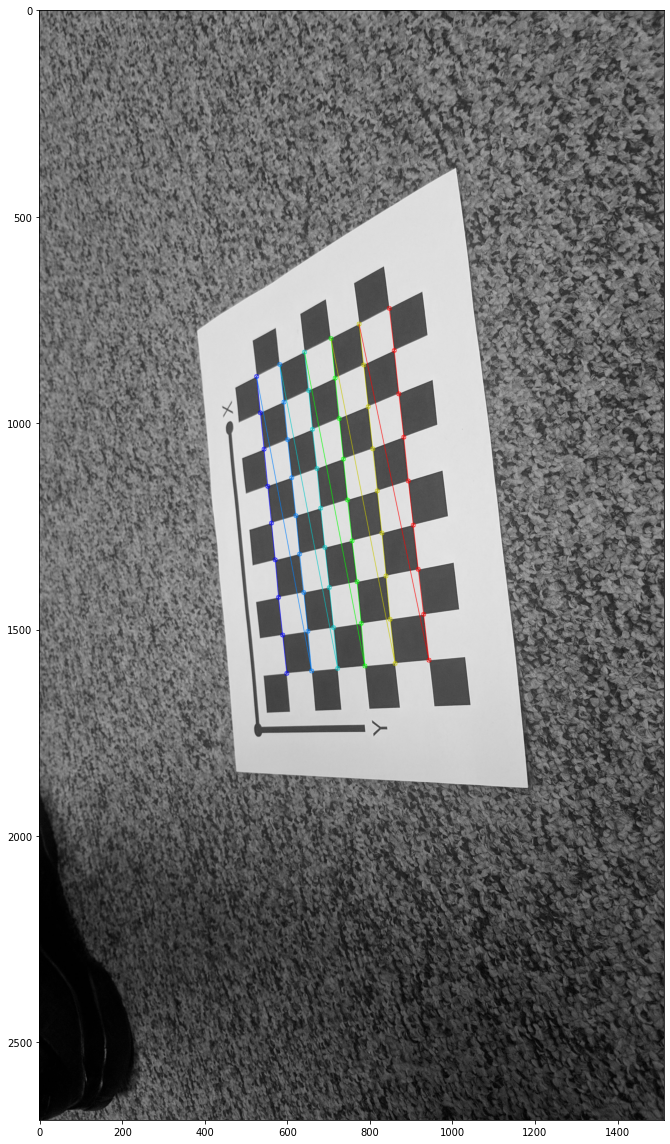

In [4]:
# Draw and display the corners
img_w_corners = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
cv.drawChessboardCorners(img_w_corners, (9,6), corners2, ret)
fig, ax = plt.subplots(figsize=(18, 16))
ax.imshow(img_w_corners, cmap='gray')
plt.tight_layout()

# Find homography of given images

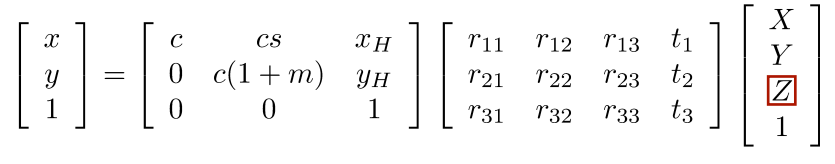

Since the calibration board is a flat surface, the Z coordinate of each point on the checkboard is equal to zero. 
Therefore the equation on the above can be expressed as below.

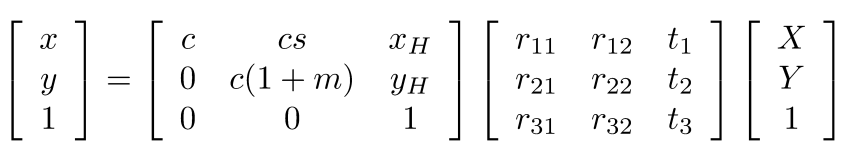

Now one point observed on the checkerboard generates such an equation.
We have 13(number of image) and 54(9x6 calibration pattern) points pair, therefore we have total of 702(13 * 54) equation of the above equation.

**How can we solve this?**

We can express equation as DLT-Like Estimation


We can estimate H via SVD.
We will have 13 homography matrix. 

In [5]:
H = []
# create matrix for DLT-like estimation
for i in range(len(objpoints)):
    M = []
    for j in range(len(objpoints[i])):
        x, y = imgpoints[i][j][0]
        X, Y, Z = objpoints[i][j]
        M.append([X, Y, 1, 0, 0, 0, -x*X, -x*Y, -x])
        M.append([0, 0, 0, X, Y, 1, -y*X, -y*Y, -y])
    M = np.array(M)

    # Find optimal p with SVD
    U, S, V = np.linalg.svd(M)
    p = V[-1]   
    print("Residual: {}".format(np.linalg.norm(np.dot(M, p))))
    h = p.reshape(3, 3)
    h /= h[2,2]
    H.append(h)

Residual: 0.003997082204240185
Residual: 0.0041102966437888445
Residual: 0.005577375615518662
Residual: 0.0065965421769578385
Residual: 0.0027081447035407773
Residual: 0.003474449537382721
Residual: 0.0015540303496427005
Residual: 0.002324063561991148
Residual: 0.002866339730272096
Residual: 0.003456702441696066
Residual: 0.0050781978488299035
Residual: 0.006751333960041107
Residual: 0.0034320576046851974


In [6]:
H[0]

array([[ 5.83077643e-01,  5.46207433e+00,  4.34088804e+02],
       [-4.72148893e+00,  2.27194479e-02,  1.39946407e+03],
       [ 5.06237825e-04, -9.42343397e-05,  1.00000000e+00]])

# Decompose the homography matrix H with K(calibration matrix) and R, T(rotation and translation)

not applicable QR composition -> use SVD

1. Exploit constraints about K, r1, r2
    K <- invertible matrix -> r1 = K^-1h1 -> r2 = K^-1h2
    r_1, r_2 are rotation for each direction -> form a orthonomal basis -> r_1^Tr_2 =0 ||r_1||=||r_2||=1

$h_1^TK^{-T}K^{-1}h_2 = 0$

$h_1^T K^{-T} K^{-1} h_1 = h_2^T K^{-T} K^{-1} h_2 \leftrightarrow h_1^T K^{-T} K^{-1} h_1 - h_2^T K^{-T} K^{-1} h_2 = 0$

2. Define a positive semidefinite matrix matrix $B =K^{-T}K^{-1}$ 

$h_1^TBh_2 = 0$

$h_1^T B h_1 = h_2^T B h_2 \leftrightarrow h_1^T B h_1 - h_2^T B h_2 = 0$

3. This B can be computed by solving another homogeneous linear system

$chol(B) = AA^T \Leftrightarrow A = K^{-T} $

If we know B, then we can compute K

4. Decompose matrix B

In [7]:
## create matrix V for calculate B
def get_Vt(H, i, j):
    v_t = [H[0,i]*H[0,j], 
           H[0,i]*H[1,j]+H[1,i]*H[0,j],
           H[2,i]*H[0,j]+H[0,i]*H[2,j],
           H[1,i]*H[1,j],
           H[2,i]*H[1,j]+H[1,i]*H[2,j],
           H[2,i]*H[2,j]]
    return v_t

## first build up matrix V for all images
V = []
for i in tqdm(range(len(objpoints))):
    Vt_12 = get_Vt(H[i], 0, 1)
    Vt_11 = get_Vt(H[i], 0, 0)
    Vt_22 = get_Vt(H[i], 1, 1)
    V.append(np.array(Vt_12))
    V.append(np.array(Vt_11) - np.array(Vt_22))

# Find B with SVD
V = np.array(V)
print(V.shape)
U, S, V = np.linalg.svd(V)
b = V[-1]
print("Residual: {}".format(np.linalg.norm(np.dot(V, b))))
B = np.array([[b[0], b[1], b[2]],
                [b[1], b[3], b[4]],
                [b[2], b[4], b[5]]])
print("B: {}, ||B||: {}".format(B, np.linalg.norm(B)))


#find K with Cholesky decomposition
A = np.array(scipy.linalg.cholesky(B, lower=True))

print("A:{}".format(A))

K = np.linalg.inv(np.transpose(A))
K /= K[2,2]
print("K: {}".format(K))
A_inv = np.linalg.inv(K)

# get rotation and translation for each image
print("Get Rotation and Translation vector for each image")
R = []
T = []
for i in tqdm(range(len(objpoints))):
    h1 = H[i][:,0]
    h2 = H[i][:,1]
    h3 = H[i][:,2]
    lam = 1/np.linalg.norm(np.dot(A_inv, h1), 2)
    r1 = lam * np.dot(A_inv, h1)
    r2 = lam * np.dot(A_inv, h2)
    t = lam * np.dot(A_inv, h3)
    r = np.array([r1, r2]).transpose()
    R.append(r)
    T.append(t)
    print(K, r, t)
    

  0%|          | 0/13 [00:00<?, ?it/s]

(26, 6)
Residual: 0.9999999999999997
B: [[ 1.50143136e-07  8.28736926e-11 -1.14436172e-04]
 [ 8.28736926e-11  1.52412972e-07 -2.05856615e-04]
 [-1.14436172e-04 -2.05856615e-04  9.99999972e-01]], ||B||: 1.000000027736291
A:[[ 3.87483078e-04  0.00000000e+00  0.00000000e+00]
 [ 2.13876934e-07  3.90400981e-04  0.00000000e+00]
 [-2.95332049e-01 -5.27133537e-01  7.96811889e-01]]
K: [[ 2.05637855e+03 -1.12656463e+00  7.61435225e+02]
 [ 0.00000000e+00  2.04100893e+03  1.35023620e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Get Rotation and Translation vector for each image


  0%|          | 0/13 [00:00<?, ?it/s]

[[ 2.05637855e+03 -1.12656463e+00  7.61435225e+02]
 [ 0.00000000e+00  2.04100893e+03  1.35023620e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 0.03508211  0.99750444]
 [-0.98160993  0.02723395]
 [ 0.18764646 -0.03492971]] [-59.0003049    8.94029672 370.66857955]
[[ 2.05637855e+03 -1.12656463e+00  7.61435225e+02]
 [ 0.00000000e+00  2.04100893e+03  1.35023620e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 0.03439628  1.00080101]
 [-0.94377139  0.0350406 ]
 [ 0.32880459  0.00196779]] [-65.23016843  20.89417023 335.77021471]
[[ 2.05637855e+03 -1.12656463e+00  7.61435225e+02]
 [ 0.00000000e+00  2.04100893e+03  1.35023620e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 0.04115065  0.99757319]
 [-0.89627727  0.06167465]
 [ 0.44158088  0.03967824]] [-6.18868871e+01 -1.98911112e-01  3.16163720e+02]
[[ 2.05637855e+03 -1.12656463e+00  7.61435225e+02]
 [ 0.00000000e+00  2.04100893e+03  1.35023620e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-0.0

We found a closed-form solution of K with pinhole camera model,
now expand for more realistic camera model with radial distortion
since the model with radial distortion is non-linear model, 
we now optimize with Levenverg-Marquardt(LM) method

Now optimize with maximize likelihood estimation with LM method

In [8]:
# define reprojection error for each image

def reproject_points(idx_img, objpoints, imgpoints, x0, R, T):
    k = get_A_from_x0(x0)
    alpha, gamma, beta, u0, v0, k1, k2 = x0
    Rt = np.concatenate([R[idx_img], np.expand_dims(T[idx_img],axis=0).transpose()],axis=1)
    imgpoints_projected = []
    for idx_corner in range(0, objpoints.shape[1]):
        imgpoints_proj = np.dot(np.dot(k, Rt), np.transpose(objpoints[idx_img, idx_corner]))
        x = imgpoints_proj[0]
        y = imgpoints_proj[1]
        r2 = x**2 + y**2
        radial_distortion = 1 + k1*r2 + k2*r2**2
        imgpoints_proj[0] *= radial_distortion
        imgpoints_proj[1] *= radial_distortion
        imgpoints_proj /= imgpoints_proj[2]
        imgpoints_projected.append(imgpoints_proj[:2])
        print(imgpoints_proj[:2])
    imgpoints_projected = np.array(imgpoints_projected)
    e = np.linalg.norm((imgpoints[idx_img] - imgpoints_projected), ord=2) / objpoints.shape[1]
    print("Reprojection Error: {}".format(e))
    print(imgpoints_projected.shape)
    
    plt.imshow(images_gray[idx_img], cmap='gray')
    plt.plot(imgpoints_projected[:,0], imgpoints_projected[:,1], 'ro')
    
# construct camera matrix A from x0
def get_A_from_x0(x0):
    alpha, gamma, beta, u0, v0, _, _ = x0
    A = np.array([[alpha, gamma, u0],
                    [0, beta, v0],
                    [0, 0, 1]])
    return A


def loss_func(x0, init_R, init_T, imgpoints, objpoints):
    A = get_A_from_x0(x0)
    alpha, gamma, beta, u0, v0, k1, k2 = x0
    error_mat = []
    for idx_img in range(0, objpoints.shape[0]):
        Rt = np.concatenate([init_R[idx_img], np.expand_dims(init_T[idx_img],axis=0).transpose()],axis=1)
        imgpoints_projected = []
        for idx_corner in range(0, objpoints.shape[1]):
            imgpoints_proj = np.dot(K*Rt, np.transpose(objpoints[idx_img, idx_corner]))
            x = imgpoints_proj[0]
            y = imgpoints_proj[1]
            r2 = x**2 + y**2
            radial_distortion = 1 + k1*r2 + k2*r2**2
            imgpoints_proj[0] *= radial_distortion
            imgpoints_proj[1] *= radial_distortion
            imgpoints_proj /= imgpoints_proj[2]
            imgpoints_projected.append(imgpoints_proj[:2])
        imgpoints_projected = np.array(imgpoints_projected)
        e = np.linalg.norm((imgpoints[idx_img] - imgpoints_projected), ord=2) / objpoints.shape[1]
        error_mat.append(e)
    return np.array(error_mat)

def draw_imgpoints(idx_img):
    plt.imshow(images_gray[idx_img], cmap='gray')
    plt.plot(imgpoints[idx_img,:,0,0], imgpoints[idx_img,:,0,1], 'ro')


[ 434.0888035  1399.46407094]
[ 441.81619533 1283.97710667]
[ 449.3789592  1170.95053052]
[ 456.78230063 1060.3065453 ]
[464.03120796 951.97059956]
[471.13046357 845.87122003]
[478.08465438 741.93985437]
[484.89818176 640.11072349]
[491.57527083 540.32068269]
[ 552.64307755 1402.79465477]
[ 559.10695949 1287.03983175]
[ 565.43285827 1173.7560031 ]
[ 571.62514548 1062.86488269]
[577.68800998 954.29145684]
[583.62546732 847.96381512]
[589.44136864 743.81299149]
[595.13940899 641.77281516]
[600.72313518 541.77977038]
[ 671.67969709 1406.13878929]
[ 676.86976977 1290.11488302]
[ 681.94883047 1176.57264579]
[ 686.92040322 1065.43329842]
[691.78786442 956.6213612 ]
[696.55445055 850.06448295]
[701.2232653  745.69328063]
[705.79728634 643.44118862]
[710.27937164 543.24431719]
[ 791.20161181 1409.49655737]
[ 795.1074816  1293.20233503]
[ 798.92964095 1179.40052542]
[ 802.67075246 1068.01185216]
[806.33336697 958.96036563]
[809.9199294  852.17327033]
[813.43278418 747.58076282]
[816.87418035 64

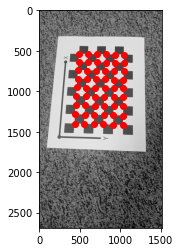

In [9]:
alpha = K[0,0]
gamma = K[0,1]
beta = K[1,1] 
u0 = K[0,2]
v0 = K[1,2]
k1 = 0
k2 = 0
x0=[alpha, gamma, beta, u0, v0, k1, k2]
reproject_points(0, objpoints, imgpoints[:,:,0,:], x0, R, T)

In [11]:
# optimize M for entire images with radial distortion via Levenberg-Marquardt algorithm
import scipy.optimize
res = scipy.optimize.least_squares(fun=loss_func, 
                                   method="lm", 
                                   x0=[alpha, gamma, beta, u0, v0, k1, k2], 
                                   args=(R, T, imgpoints[:,:,0,:], objpoints))

In [12]:
K = get_A_from_x0(res.x)
A_inv = np.linalg.inv(K)

print("Get Rotation and Translation vector for each image")
R = []
T = []
for i in tqdm(range(len(objpoints))):
    h1 = H[i][:,0]
    h2 = H[i][:,1]
    h3 = H[i][:,2]
    lam = 1/np.linalg.norm(np.dot(A_inv, h1), 2)
    r1 = lam * np.dot(A_inv, h1)
    r2 = lam * np.dot(A_inv, h2)
    t = lam * np.dot(A_inv, h3)
    r = np.array([r1, r2]).transpose()
    R.append(r)
    T.append(t)
    print (r, t)

Get Rotation and Translation vector for each image


  0%|          | 0/13 [00:00<?, ?it/s]

[[ 0.03508211  0.99750444]
 [-0.98160993  0.02723395]
 [ 0.18764646 -0.03492971]] [-59.0003049    8.94029672 370.66857955]
[[ 0.03439628  1.00080101]
 [-0.94377139  0.0350406 ]
 [ 0.32880459  0.00196779]] [-65.23016843  20.89417023 335.77021471]
[[ 0.04115065  0.99757319]
 [-0.89627727  0.06167465]
 [ 0.44158088  0.03967824]] [-6.18868871e+01 -1.98911112e-01  3.16163720e+02]
[[-0.00245495  0.99926594]
 [-0.85260661  0.03442872]
 [ 0.52254755  0.06931344]] [-58.7617195   -1.76675526 294.1531274 ]
[[-4.97033984e-03  9.95675705e-01]
 [-9.99984879e-01 -6.92444897e-03]
 [-2.35298659e-03 -7.94871790e-05]] [-62.52898829  68.87912501 422.02988208]
[[-0.01153215  0.99652143]
 [-0.99929049 -0.00956635]
 [ 0.03585413  0.01988455]] [-57.73884098  51.536285   314.66441393]
[[ 0.02575226  0.99394464]
 [-0.99575613  0.02574654]
 [ 0.08835467 -0.01735303]] [-59.78400336  96.15682363 615.69308897]
[[-0.00287636  0.98735034]
 [-0.95521335  0.0164139 ]
 [-0.29590401 -0.07859719]] [-43.15000796  48.852125

In [13]:
alpha, gamma, beta, u0, v0, k1, k2 = res.x
res = scipy.optimize.least_squares(fun=loss_func, method="lm",
                                   x0=[alpha, gamma, beta, u0, v0, k1, k2], 
                                   args=(R, T, imgpoints[:,:,0,:], objpoints))

# Reproject Points in the Image

[ 434.0888035  1399.46407094]
[ 441.81619533 1283.97710667]
[ 449.3789592  1170.95053052]
[ 456.78230063 1060.3065453 ]
[464.03120796 951.97059956]
[471.13046357 845.87122003]
[478.08465438 741.93985437]
[484.89818176 640.11072349]
[491.57527083 540.32068269]
[ 552.64307755 1402.79465477]
[ 559.10695949 1287.03983175]
[ 565.43285827 1173.7560031 ]
[ 571.62514548 1062.86488269]
[577.68800998 954.29145684]
[583.62546732 847.96381512]
[589.44136864 743.81299149]
[595.13940899 641.77281516]
[600.72313518 541.77977038]
[ 671.67969709 1406.13878929]
[ 676.86976977 1290.11488302]
[ 681.94883047 1176.57264579]
[ 686.92040322 1065.43329842]
[691.78786442 956.6213612 ]
[696.55445055 850.06448295]
[701.2232653  745.69328063]
[705.79728634 643.44118862]
[710.27937164 543.24431719]
[ 791.20161181 1409.49655737]
[ 795.1074816  1293.20233503]
[ 798.92964095 1179.40052542]
[ 802.67075246 1068.01185216]
[806.33336697 958.96036563]
[809.9199294  852.17327033]
[813.43278418 747.58076282]
[816.87418035 64

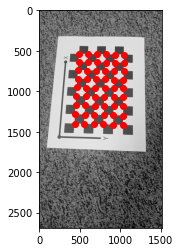

In [14]:
alpha, gamma, beta, u0, v0, k1, k2 = res.x
reproject_points(0, objpoints, imgpoints[:,:,0,:], res.x, R, T)